#### By: Peyman Shahidi
#### Created: Oct 29, 2025
#### Last Edit: Oct 30, 2025

<br>

In [821]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [822]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_BLS_matchedEmpShares'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index/sectorWeighted_analysis"

In [823]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [824]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [825]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [826]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


In [827]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

In [828]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [829]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [830]:
# Keep relevant columns
cols = ['Detailed_Occupation_Code', 'Detailed_Occupation_Title',
        'Task ID', 'Task Title',
       'Task Type', 'Task_Time_Percentage', 'Hourly_Mean_Wage',
       'gpt4_exposure', 'human_labels',
       'automation', 'augmentation', 'label']
merged_data = merged_data[cols]
merged_data.head()

,Detailed_Occupation_Code,Detailed_Occupation_Title,Task ID,Task Title,Task Type,Task_Time_Percentage,Hourly_Mean_Wage,gpt4_exposure,human_labels,automation,augmentation,label
0,11-1011,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,9.62,124.47,NaN,NaN,0.35,0.57,Augmentation
1,11-1011,Chief Executives,8824,"Confer with board members, organization offici...",Core,9.49,124.47,E0,E0,0.25,0.61,Augmentation
2,11-1011,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,9.22,124.47,E2,E2,0.31,0.66,Augmentation
3,11-1011,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,10.26,124.47,E2,E0,NaN,NaN,Manual
4,11-1011,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,1.46,124.47,E2,E2,NaN,NaN,Manual


In [831]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['Detailed_Occupation_Code', 'Detailed_Occupation_Title']):
    num_tasks = group['Task ID'].nunique()
    # num_occupations = group['Detailed_Occupation_Code'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    gpt4_E0_fraction = (group['gpt4_exposure'] == 'E0').sum() / total_tasks
    gpt4_E1_fraction = (group['gpt4_exposure'] == 'E1').sum() / total_tasks
    gpt4_E2_fraction = (group['gpt4_exposure'] == 'E2').sum() / total_tasks
    gpt4_aiExposure_fraction = gpt4_E1_fraction + gpt4_E2_fraction
    human_E0_fraction = (group['human_labels'] == 'E0').sum() / total_tasks
    human_E1_fraction = (group['human_labels'] == 'E1').sum() / total_tasks
    human_E2_fraction = (group['human_labels'] == 'E2').sum() / total_tasks
    human_aiExposure_fraction = human_E1_fraction + human_E2_fraction

    
    occupation_stats.append({
        'Detailed_Occupation_Code': soc_code,
        'Detailed_Occupation_Title': occ_title,
        'num_tasks': num_tasks,
        # 'num_occupations': num_occupations,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction,
        'gpt4_E0_fraction': gpt4_E0_fraction,
        'gpt4_E1_fraction': gpt4_E1_fraction,
        'gpt4_E2_fraction': gpt4_E2_fraction,
        'gpt4_aiExposure_fraction': gpt4_aiExposure_fraction,
        'human_E0_fraction': human_E0_fraction,
        'human_E1_fraction': human_E1_fraction,
        'human_E2_fraction': human_E2_fraction,
        'human_aiExposure_fraction': human_aiExposure_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/anthropic_detailedOccupationLevel_taskExposure_dataset.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head(5)

Number of occupations: 759
Range of tasks per occupation: 4 - 173

Sample of occupation analysis:


,Detailed_Occupation_Code,Detailed_Occupation_Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction,gpt4_E0_fraction,gpt4_E1_fraction,gpt4_E2_fraction,gpt4_aiExposure_fraction,human_E0_fraction,human_E1_fraction,human_E2_fraction,human_aiExposure_fraction
0,11-1011,Chief Executives,49,0.73,0.27,0.27,0.00,0.14,0.12,0.71,0.84,0.39,0.12,0.47,0.59
1,11-1021,General and Operations Managers,17,0.94,0.06,0.06,0.00,0.06,0.00,0.94,0.94,0.35,0.12,0.53,0.65
2,11-2011,Advertising and Promotions Managers,21,0.86,0.14,0.14,0.00,0.05,0.00,0.95,0.95,0.19,0.29,0.52,0.81
3,11-2021,Marketing Managers,20,0.70,0.30,0.30,0.00,0.05,0.05,0.90,0.95,0.05,0.25,0.70,0.95
4,11-2022,Sales Managers,17,0.82,0.18,0.18,0.00,0.12,0.00,0.88,0.88,0.12,0.12,0.76,0.88


In [832]:
# Merge industry employment share weights for all NAICS sectors and create a master dataset
bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')

# Drop rows whose industry employment share is NaN or 0
bls_sector_shares = bls_sector_shares.dropna(subset=['occ_sectorEmpShare'])
bls_sector_shares = bls_sector_shares[bls_sector_shares['occ_sectorEmpShare'] > 0].reset_index(drop=True)

# Ensure NAICS is string for consistent merging
bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)

unique_sectors = bls_sector_shares['NAICS'].unique()
print(f"Found {len(unique_sectors)} unique NAICS sectors to process")

master_dfs = []
processed_sectors = []

for sector_code in unique_sectors:
    sector_weights_df = bls_sector_shares[bls_sector_shares.NAICS == sector_code]

    # Merge occupation-level analysis with this sector's weights
    sector_occupation_analysis = occupation_analysis.merge(
        sector_weights_df[['NAICS', 'NAICS_TITLE', 'OCC_CODE', 'TOT_EMP', 'totalSectorEmp', 'sectorEmpShare', 'occ_sectorEmpShare', 'occ_totalEmpShare']],
        left_on='Detailed_Occupation_Code',
        right_on='OCC_CODE',
        how='inner'
    )
    # Drop the OCC_CODE column after merge
    sector_occupation_analysis = sector_occupation_analysis.drop(columns=['OCC_CODE'])

    # Append to master list
    master_dfs.append(sector_occupation_analysis)
    processed_sectors.append(sector_code)

# Concatenate all sector-specific records into a master dataframe
if master_dfs:
    master_df = pd.concat(master_dfs, ignore_index=True)
else:
    master_df = pd.DataFrame()

print(f"Processed {len(processed_sectors)} sectors. Master dataset rows: {len(master_df):,}")

# Save per-sector CSVs and the master CSV
for sec in unique_sectors:
    df_sec = master_df[master_df['NAICS'] == sec].copy()
    out_path = f"{output_data_path}/detailedOccupationLevel_taskExposureAIability_sector_{sec}.csv"
    df_sec.to_csv(out_path, index=False)

master_out = f"{output_data_path}/detailedOccupationLevel_taskExposureAIability_all_sectors.csv"
master_df.to_csv(master_out, index=False)

print(f"Saved {len(master_df['NAICS'].unique())} per-sector files and master file to: {output_data_path}")

Found 20 unique NAICS sectors to process
Processed 20 sectors. Master dataset rows: 7,163
Saved 20 per-sector files and master file to: ../data/computed_objects/ONET_BLS_matchedEmpShares


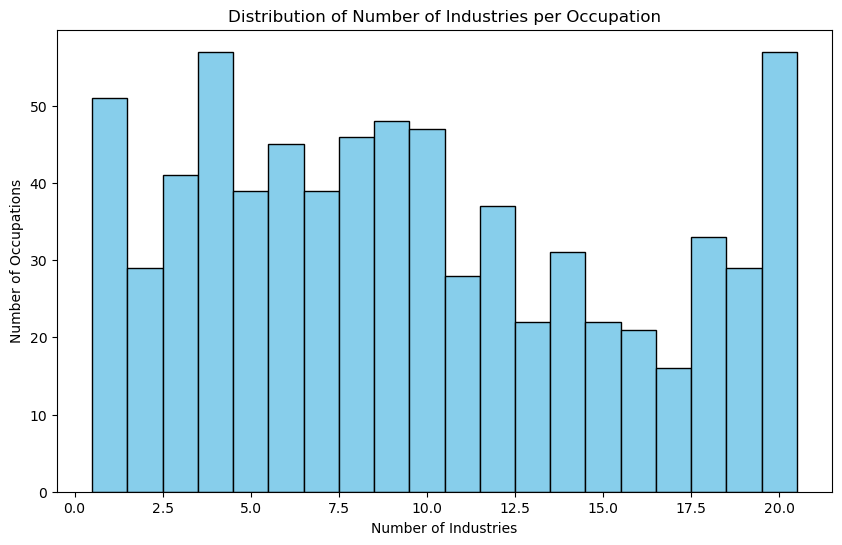

In [833]:
# Count how many industries each occupation appears in
occupation_industry_counts = master_df.groupby(['Detailed_Occupation_Code', 'Detailed_Occupation_Title'])['NAICS'].nunique().reset_index()
occupation_industry_counts = occupation_industry_counts.rename(columns={'NAICS': 'num_industries'})
occupation_industry_counts = occupation_industry_counts.sort_values(by=['num_industries', 'Detailed_Occupation_Code'], ascending=[False, True]).reset_index(drop=True)

# Plot histogram of number of industries per occupation
plt.figure(figsize=(10, 6))
plt.hist(occupation_industry_counts['num_industries'], bins=range(1, occupation_industry_counts['num_industries'].max() + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Industries per Occupation')
plt.xlabel('Number of Industries')
plt.ylabel('Number of Occupations')
# plt.savefig(f'{output_plot_path}/occupation_industry_count_distribution.png')
plt.show()

## Plot + Regression for three weighting schemes:
1) Weight each occupation by number of repetitions in dataset (i.e., pooled regression on entire dataset)
2) Weight each occupation by its total employment across all industries
3) Weight all occupations within a sector by that sector's overall weight

Regression sample size: 7,163 rows
                            OLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.84
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           0.000201
Time:                        12:25:39   Log-Likelihood:                 4012.6
No. Observations:                7163   AIC:                            -8021.
Df Residuals:                    7161   BIC:                            -8007.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.

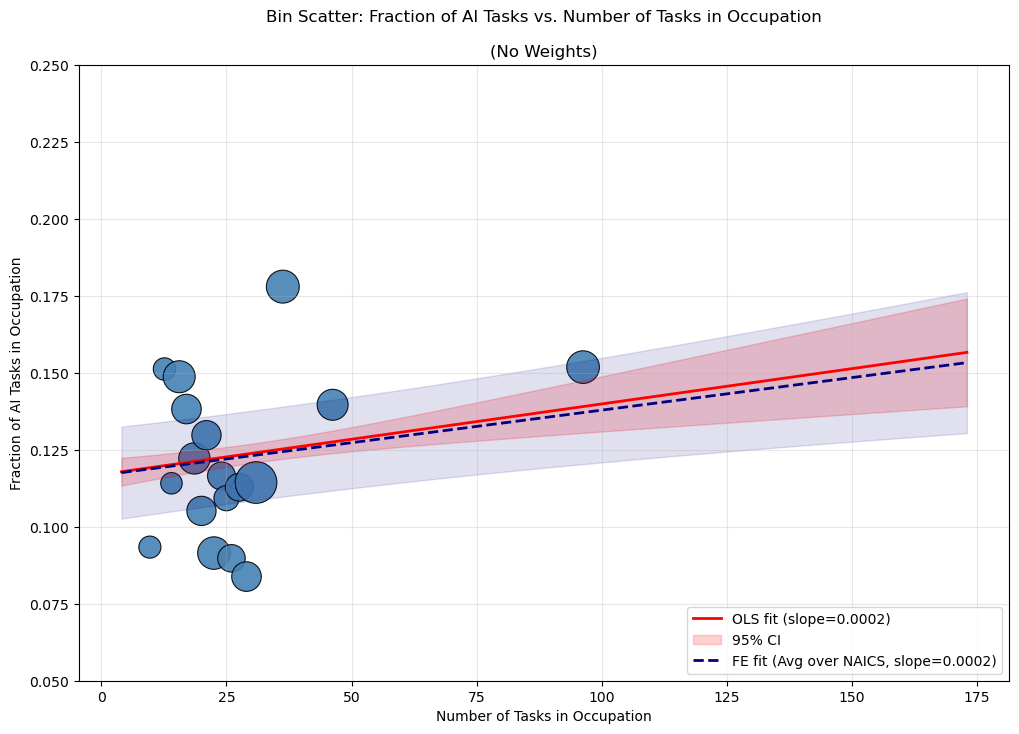

In [834]:
# Regression and binned-scatter plot: ai_fraction ~ num_tasks (with NAICS FE line)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ================================
# CONFIG
# ================================
# Set this to a numeric column name to size bubbles by its bin-sum (e.g., 'TOT_EMP').
# Set to None to size by the number of observations in each bin.
weight_col = 'TOT_EMP'   # or None

# Number of quantile bins for num_tasks
q = 20

# Optional: where to save the figure. Must exist.
# out path variable expected from your environment:
# output_plot_path = "/path/to/plots"

# ================================
# DATA PREP
# ================================
df = master_df.copy()

cols_needed = ['ai_fraction', 'num_tasks', 'NAICS']
if weight_col is not None:
    cols_needed.append(weight_col)

missing_cols = [c for c in cols_needed if c not in df.columns]
if missing_cols:
    raise KeyError(f"These columns are missing from master_df: {missing_cols}")

# Keep only rows with needed variables (allow NA in NAICS; statsmodels will handle)
df = df.loc[df['ai_fraction'].notna() & df['num_tasks'].notna(), cols_needed].copy()

# Coerce numeric fields
df['num_tasks']   = pd.to_numeric(df['num_tasks'], errors='coerce')
df['ai_fraction'] = pd.to_numeric(df['ai_fraction'], errors='coerce')
if weight_col is not None:
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')

# Drop rows with missing core vars for regression
df = df.dropna(subset=['num_tasks', 'ai_fraction']).reset_index(drop=True)
print(f"Regression sample size: {len(df):,} rows")

# ================================
# REGRESSIONS
# ================================
model_ols = smf.ols('ai_fraction ~ num_tasks', data=df).fit(cov_type='HC3')
print(model_ols.summary())

# NAICS fixed effects via C(NAICS)
model_fe = smf.ols('ai_fraction ~ num_tasks + C(NAICS)', data=df).fit(cov_type='HC3')
print(model_fe.summary())

# ================================
# BINNED SCATTER (by num_tasks)
# ================================
unique_vals = df['num_tasks'].nunique()
q_use = min(q, unique_vals) if unique_vals > 1 else 1

try:
    bins = pd.qcut(df['num_tasks'], q=q_use, duplicates='drop')
except Exception:
    bins = pd.cut(df['num_tasks'], bins=q_use)

agg_dict = {
    'num_tasks_mean': ('num_tasks', 'mean'),
    'ai_fraction_mean': ('ai_fraction', 'mean'),
    'count': ('ai_fraction', 'count'),
}
if weight_col is not None and weight_col in df.columns:
    agg_dict['weight_sum'] = (weight_col, 'sum')

binned = df.groupby(bins).agg(**agg_dict).reset_index(drop=True)

# Decide the size metric + label
if 'weight_sum' in binned.columns and binned['weight_sum'].notna().any():
    size_metric = binned['weight_sum'].fillna(0.0)
    size_label = f'sum {weight_col} (per bin)'
else:
    size_metric = binned['count']
    size_label = 'observations (per bin)'

# ================================
# PLOT
# ================================
plt.figure(figsize=(12, 8))

# Scale bubble area ~ size_metric (in points^2)
s_min, s_max = 40, 900
if size_metric.max() > 0:
    sizes = s_min + (s_max - s_min) * (size_metric / size_metric.max())
else:
    sizes = np.full(len(size_metric), s_min)

# Single color, no colorbar (removes side highlight bar)
sc = plt.scatter(
    binned['num_tasks_mean'], binned['ai_fraction_mean'],
    s=sizes, c='steelblue', edgecolor='black', linewidth=0.8, alpha=0.9
)

plt.xlabel('Number of Tasks in Occupation')
plt.ylabel('Fraction of AI Tasks in Occupation')
plt.ylim(0.05, 0.25)
plt.title('Bin Scatter: Fraction of AI Tasks vs. Number of Tasks in Occupation\n\n(No Weights)')

# ================================
# OVERLAY OLS LINE + 95% CI
# ================================
x_line = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)
preds_ols = model_ols.get_prediction(pd.DataFrame({'num_tasks': x_line}))
pred_df_ols = preds_ols.summary_frame(alpha=0.05)

slope_ols = float(model_ols.params['num_tasks'])
plt.plot(x_line, pred_df_ols['mean'], color='red', lw=2,
         label=f'OLS fit (slope={slope_ols:.4f})')
plt.fill_between(x_line, pred_df_ols['mean_ci_lower'], pred_df_ols['mean_ci_upper'],
                 color='red', alpha=0.18, label='95% CI')

# ================================
# OVERLAY FE LINE + 95% CI (average over NAICS categories)
# ================================
cats = pd.unique(df['NAICS'])
mean_lines, low_lines, up_lines = [], [], []
for g in cats:
    Xg = pd.DataFrame({'num_tasks': x_line, 'NAICS': g})
    # keep categorical dtype consistent if applicable
    if pd.api.types.is_categorical_dtype(df['NAICS']):
        Xg['NAICS'] = pd.Categorical([g]*len(x_line), categories=df['NAICS'].cat.categories)
    sf = model_fe.get_prediction(Xg).summary_frame(alpha=0.05)
    mean_lines.append(sf['mean'].to_numpy())
    low_lines.append(sf['mean_ci_lower'].to_numpy())
    up_lines.append(sf['mean_ci_upper'].to_numpy())

mean_line = np.vstack(mean_lines).mean(axis=0)
low_band  = np.vstack(low_lines).mean(axis=0)
up_band   = np.vstack(up_lines).mean(axis=0)
slope_fe = float(model_fe.params['num_tasks'])

plt.plot(x_line, mean_line, color='navy', lw=2, ls='--',
         label=f'FE fit (Avg over NAICS, slope={slope_fe:.4f})')
plt.fill_between(x_line, low_band, up_band, color='navy', alpha=0.12)

plt.grid(alpha=0.3)
plt.legend(loc='lower right')

# ================================
# SAVE / SHOW
# ================================
try:
    size_tag = "weight" if 'weight_sum' in binned.columns else "count"
    out_file = f'{output_plot_path}/aiFraction_vs_numTasks_noWeights.png'
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    print(f"Saved plot to: {out_file}")
except Exception as e:
    print(f"(Skipping save) {e}")

plt.show()

Weighted regression sample size (rows with non-missing values): 7,163
                            WLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03843
Date:                Thu, 30 Oct 2025   Prob (F-statistic):              0.845
Time:                        12:25:40   Log-Likelihood:                -4629.5
No. Observations:                7163   AIC:                             9263.
Df Residuals:                    7161   BIC:                             9277.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

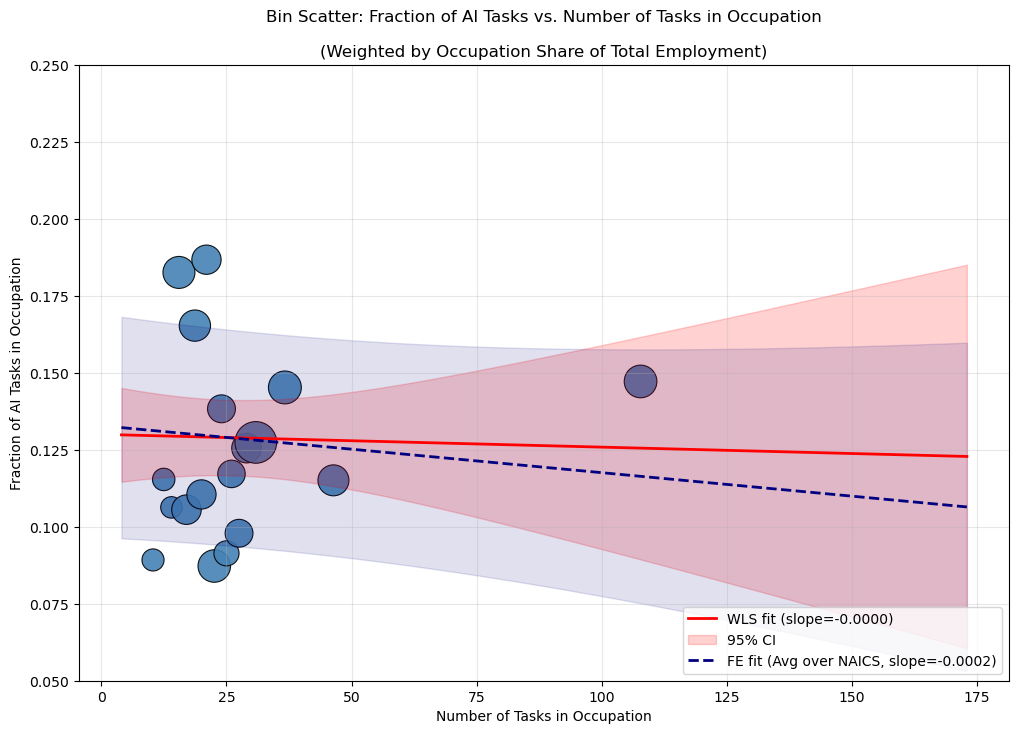

In [835]:
# Weighted regression and weighted binned scatter using occ_totalEmpShare as weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ================================
# CONFIG
# ================================
weight_col = 'occ_totalEmpShare'  # weight for WLS and bin-size aggregation
q = 20                            # number of quantile bins for num_tasks
# output_plot_path should already exist

# ================================
# DATA PREP
# ================================
df = master_df[['ai_fraction', 'num_tasks', weight_col, 'NAICS']].copy()
df = df[df['ai_fraction'].notna() & df['num_tasks'].notna()].copy()

# Coerce numeric
df['num_tasks'] = pd.to_numeric(df['num_tasks'], errors='coerce')
df['ai_fraction'] = pd.to_numeric(df['ai_fraction'], errors='coerce')
df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')

# Drop rows with missing core vars
df = df.dropna(subset=['num_tasks', 'ai_fraction', weight_col]).reset_index(drop=True)

# Ensure positive weights
if (df[weight_col] <= 0).all():
    raise ValueError(f"All weights in `{weight_col}` are <= 0. Need positive weights for WLS.")
if (df[weight_col] == 0).any():
    print(f"Warning: {int((df[weight_col] == 0).sum())} rows have zero weights and will not influence the weighted fit.")

print(f"Weighted regression sample size (rows with non-missing values): {len(df):,}")

# ================================
# REGRESSIONS (WLS + WLS with FE)
# ================================
model_wls = smf.wls('ai_fraction ~ num_tasks', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls.summary())

model_wls_fe = smf.wls('ai_fraction ~ num_tasks + C(NAICS)', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls_fe.summary())

# ================================
# BINNED SCATTER (weighted means within unweighted num_tasks bins)
# ================================
unique_vals = df['num_tasks'].nunique()
q_use = min(q, unique_vals) if unique_vals > 1 else 1

try:
    bins = pd.qcut(df['num_tasks'], q=q_use, duplicates='drop')
except Exception:
    bins = pd.cut(df['num_tasks'], bins=q_use)

def weighted_stats(g):
    w = g[weight_col].to_numpy()
    x = g['num_tasks'].to_numpy()
    y = g['ai_fraction'].to_numpy()
    sum_w = np.nansum(w)
    x_wmean = np.average(x, weights=w) if sum_w > 0 else np.nan
    y_wmean = np.average(y, weights=w) if sum_w > 0 else np.nan
    return pd.Series({
        'num_tasks_wmean': x_wmean,
        'ai_fraction_wmean': y_wmean,
        'sum_w': sum_w,
        'n': len(g)
    })

binned = df.groupby(bins, observed=True).apply(weighted_stats).reset_index(drop=True)

# ================================
# PLOT
# ================================
plt.figure(figsize=(12, 8))

# Bubble area scaling by summed weights
s_min, s_max = 40, 900
max_w = binned['sum_w'].max()
if pd.notna(max_w) and max_w > 0:
    sizes = s_min + (s_max - s_min) * (binned['sum_w'] / max_w)
else:
    sizes = np.full(len(binned), s_min)

# Single color, no colorbar
plt.scatter(
    binned['num_tasks_wmean'], binned['ai_fraction_wmean'],
    s=sizes, c='steelblue', edgecolor='black', linewidth=0.8, alpha=0.9
)

plt.xlabel('Number of Tasks in Occupation')
plt.ylabel('Fraction of AI Tasks in Occupation')
plt.ylim(0.05, 0.25)
plt.title('Bin Scatter: Fraction of AI Tasks vs. Number of Tasks in Occupation\n\n(Weighted by Occupation Share of Total Employment)')

# ================================
# OVERLAY WLS LINE + 95% CI
# ================================
x_line = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)
preds = model_wls.get_prediction(pd.DataFrame({'num_tasks': x_line}))
pred_df = preds.summary_frame(alpha=0.05)

slope_wls = float(model_wls.params['num_tasks'])
plt.plot(x_line, pred_df['mean'], color='red', lw=2, label=f'WLS fit (slope={slope_wls:.4f})')
plt.fill_between(x_line, pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='red', alpha=0.18, label='95% CI')

# ================================
# OVERLAY FE LINE + 95% CI (average over NAICS categories)
# ================================
cats = pd.unique(df['NAICS'])
mean_lines, low_lines, up_lines = [], [], []
for g in cats:
    Xg = pd.DataFrame({'num_tasks': x_line, 'NAICS': g})
    if pd.api.types.is_categorical_dtype(df['NAICS']):
        Xg['NAICS'] = pd.Categorical([g]*len(x_line), categories=df['NAICS'].cat.categories)
    sf = model_wls_fe.get_prediction(Xg).summary_frame(alpha=0.05)
    mean_lines.append(sf['mean'].to_numpy())
    low_lines.append(sf['mean_ci_lower'].to_numpy())
    up_lines.append(sf['mean_ci_upper'].to_numpy())

mean_line = np.vstack(mean_lines).mean(axis=0)
low_band  = np.vstack(low_lines).mean(axis=0)
up_band   = np.vstack(up_lines).mean(axis=0)
slope_fe = float(model_wls_fe.params['num_tasks'])

plt.plot(x_line, mean_line, color='navy', lw=2, ls='--', label=f'FE fit (Avg over NAICS, slope={slope_fe:.4f})')
plt.fill_between(x_line, low_band, up_band, color='navy', alpha=0.12)

plt.grid(alpha=0.3)
plt.legend(loc='lower right')

# ================================
# SAVE / SHOW
# ================================
try:
    out_file = f"{output_plot_path}/aiFraction_vs_numTasks_occupationEmpShareWeights.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    print(f"Saved weighted binned scatter + regression plot to: {out_file}")
except Exception as e:
    print(f"(Skipping save) {e}")

plt.show()

Weighted regression sample size (rows with non-missing values): 7,163
                            WLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.839
Date:                Thu, 30 Oct 2025   Prob (F-statistic):            0.00296
Time:                        12:25:41   Log-Likelihood:                 2773.8
No. Observations:                7163   AIC:                            -5544.
Df Residuals:                    7161   BIC:                            -5530.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

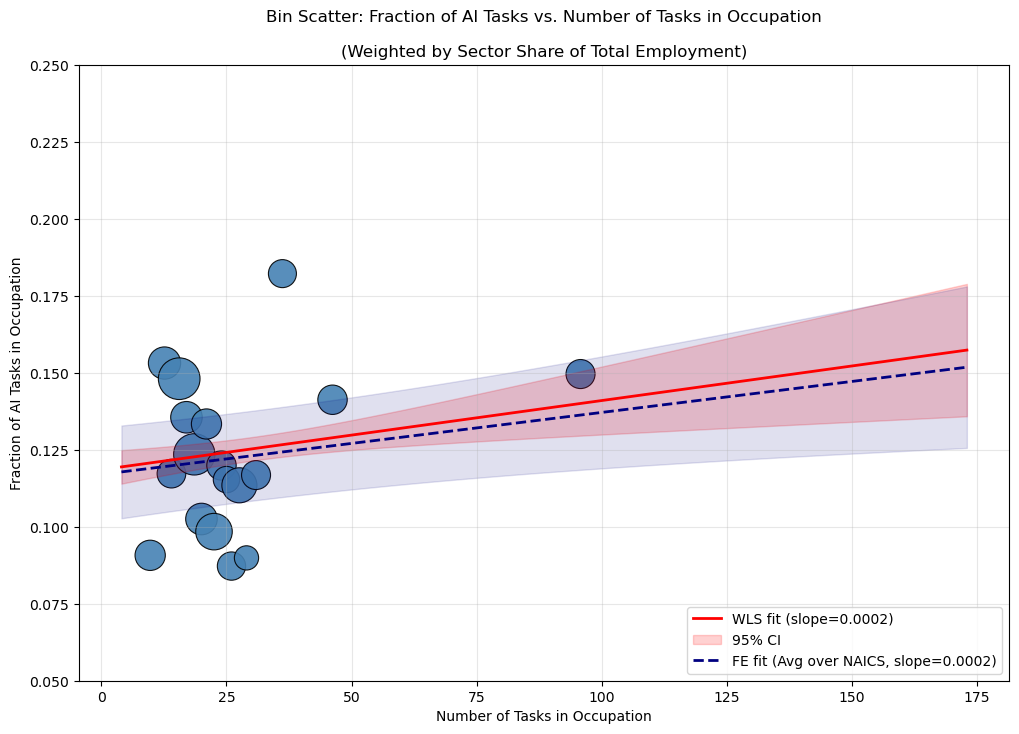

In [836]:
# Weighted regression and weighted binned scatter using sectorEmpShare as weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ================================
# CONFIG
# ================================
weight_col = 'sectorEmpShare'  # weight for WLS and bin-size aggregation
q = 20                            # number of quantile bins for num_tasks
# output_plot_path should already exist

# ================================
# DATA PREP
# ================================
df = master_df[['ai_fraction', 'num_tasks', weight_col, 'NAICS']].copy()
df = df[df['ai_fraction'].notna() & df['num_tasks'].notna()].copy()

# Coerce numeric
df['num_tasks'] = pd.to_numeric(df['num_tasks'], errors='coerce')
df['ai_fraction'] = pd.to_numeric(df['ai_fraction'], errors='coerce')
df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')

# Drop rows with missing core vars
df = df.dropna(subset=['num_tasks', 'ai_fraction', weight_col]).reset_index(drop=True)

# Ensure positive weights
if (df[weight_col] <= 0).all():
    raise ValueError(f"All weights in `{weight_col}` are <= 0. Need positive weights for WLS.")
if (df[weight_col] == 0).any():
    print(f"Warning: {int((df[weight_col] == 0).sum())} rows have zero weights and will not influence the weighted fit.")

print(f"Weighted regression sample size (rows with non-missing values): {len(df):,}")

# ================================
# REGRESSIONS (WLS + WLS with FE)
# ================================
model_wls = smf.wls('ai_fraction ~ num_tasks', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls.summary())

model_wls_fe = smf.wls('ai_fraction ~ num_tasks + C(NAICS)', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls_fe.summary())

# ================================
# BINNED SCATTER (weighted means within unweighted num_tasks bins)
# ================================
unique_vals = df['num_tasks'].nunique()
q_use = min(q, unique_vals) if unique_vals > 1 else 1

try:
    bins = pd.qcut(df['num_tasks'], q=q_use, duplicates='drop')
except Exception:
    bins = pd.cut(df['num_tasks'], bins=q_use)

def weighted_stats(g):
    w = g[weight_col].to_numpy()
    x = g['num_tasks'].to_numpy()
    y = g['ai_fraction'].to_numpy()
    sum_w = np.nansum(w)
    x_wmean = np.average(x, weights=w) if sum_w > 0 else np.nan
    y_wmean = np.average(y, weights=w) if sum_w > 0 else np.nan
    return pd.Series({
        'num_tasks_wmean': x_wmean,
        'ai_fraction_wmean': y_wmean,
        'sum_w': sum_w,
        'n': len(g)
    })

binned = df.groupby(bins, observed=True).apply(weighted_stats).reset_index(drop=True)

# ================================
# PLOT
# ================================
plt.figure(figsize=(12, 8))

# Bubble area scaling by summed weights
s_min, s_max = 40, 900
max_w = binned['sum_w'].max()
if pd.notna(max_w) and max_w > 0:
    sizes = s_min + (s_max - s_min) * (binned['sum_w'] / max_w)
else:
    sizes = np.full(len(binned), s_min)

# Single color, no colorbar
plt.scatter(
    binned['num_tasks_wmean'], binned['ai_fraction_wmean'],
    s=sizes, c='steelblue', edgecolor='black', linewidth=0.8, alpha=0.9
)

plt.xlabel('Number of Tasks in Occupation')
plt.ylabel('Fraction of AI Tasks in Occupation')
plt.ylim(0.05, 0.25)
plt.title('Bin Scatter: Fraction of AI Tasks vs. Number of Tasks in Occupation\n\n(Weighted by Sector Share of Total Employment)')

# ================================
# OVERLAY WLS LINE + 95% CI
# ================================
x_line = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)
preds = model_wls.get_prediction(pd.DataFrame({'num_tasks': x_line}))
pred_df = preds.summary_frame(alpha=0.05)

slope_wls = float(model_wls.params['num_tasks'])
plt.plot(x_line, pred_df['mean'], color='red', lw=2, label=f'WLS fit (slope={slope_wls:.4f})')
plt.fill_between(x_line, pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='red', alpha=0.18, label='95% CI')

# ================================
# OVERLAY FE LINE + 95% CI (average over NAICS categories)
# ================================
cats = pd.unique(df['NAICS'])
mean_lines, low_lines, up_lines = [], [], []
for g in cats:
    Xg = pd.DataFrame({'num_tasks': x_line, 'NAICS': g})
    if pd.api.types.is_categorical_dtype(df['NAICS']):
        Xg['NAICS'] = pd.Categorical([g]*len(x_line), categories=df['NAICS'].cat.categories)
    sf = model_wls_fe.get_prediction(Xg).summary_frame(alpha=0.05)
    mean_lines.append(sf['mean'].to_numpy())
    low_lines.append(sf['mean_ci_lower'].to_numpy())
    up_lines.append(sf['mean_ci_upper'].to_numpy())

mean_line = np.vstack(mean_lines).mean(axis=0)
low_band  = np.vstack(low_lines).mean(axis=0)
up_band   = np.vstack(up_lines).mean(axis=0)
slope_fe = float(model_wls_fe.params['num_tasks'])

plt.plot(x_line, mean_line, color='navy', lw=2, ls='--', label=f'FE fit (Avg over NAICS, slope={slope_fe:.4f})')
plt.fill_between(x_line, low_band, up_band, color='navy', alpha=0.12)

plt.grid(alpha=0.3)
plt.legend(loc='lower right')

# ================================
# SAVE / SHOW
# ================================
try:
    out_file = f"{output_plot_path}/aiFraction_vs_numTasks_sectorEmpShareWeights.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    print(f"Saved weighted binned scatter + regression plot to: {out_file}")
except Exception as e:
    print(f"(Skipping save) {e}")

plt.show()

Weighted regression sample size (rows with non-missing values): 7,163
                            WLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.344
Date:                Thu, 30 Oct 2025   Prob (F-statistic):              0.246
Time:                        12:25:41   Log-Likelihood:                -4003.8
No. Observations:                7163   AIC:                             8012.
Df Residuals:                    7161   BIC:                             8025.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

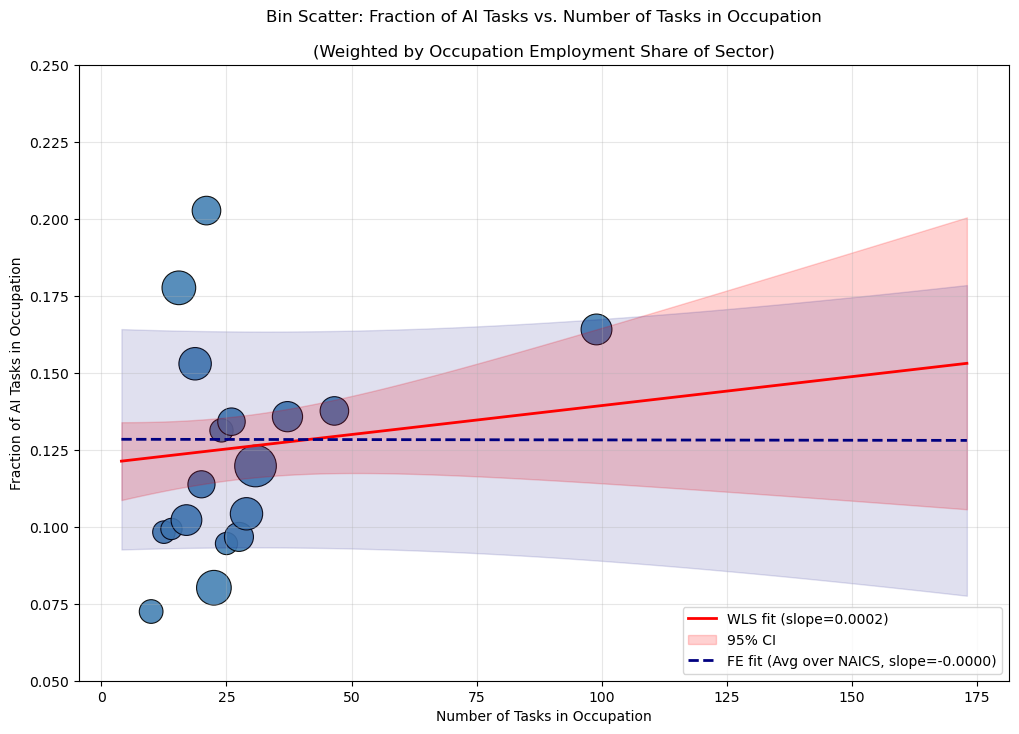

In [837]:
# Weighted regression and weighted binned scatter using occ_sectorEmpShare as weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ================================
# CONFIG
# ================================
weight_col = 'occ_sectorEmpShare'  # weight for WLS and bin-size aggregation
q = 20                            # number of quantile bins for num_tasks
# output_plot_path should already exist

# ================================
# DATA PREP
# ================================
df = master_df[['ai_fraction', 'num_tasks', weight_col, 'NAICS']].copy()
df = df[df['ai_fraction'].notna() & df['num_tasks'].notna()].copy()

# Coerce numeric
df['num_tasks'] = pd.to_numeric(df['num_tasks'], errors='coerce')
df['ai_fraction'] = pd.to_numeric(df['ai_fraction'], errors='coerce')
df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')

# Drop rows with missing core vars
df = df.dropna(subset=['num_tasks', 'ai_fraction', weight_col]).reset_index(drop=True)

# Ensure positive weights
if (df[weight_col] <= 0).all():
    raise ValueError(f"All weights in `{weight_col}` are <= 0. Need positive weights for WLS.")
if (df[weight_col] == 0).any():
    print(f"Warning: {int((df[weight_col] == 0).sum())} rows have zero weights and will not influence the weighted fit.")

print(f"Weighted regression sample size (rows with non-missing values): {len(df):,}")

# ================================
# REGRESSIONS (WLS + WLS with FE)
# ================================
model_wls = smf.wls('ai_fraction ~ num_tasks', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls.summary())

model_wls_fe = smf.wls('ai_fraction ~ num_tasks + C(NAICS)', data=df, weights=df[weight_col]).fit(cov_type='HC3')
print(model_wls_fe.summary())

# ================================
# BINNED SCATTER (weighted means within unweighted num_tasks bins)
# ================================
unique_vals = df['num_tasks'].nunique()
q_use = min(q, unique_vals) if unique_vals > 1 else 1

try:
    bins = pd.qcut(df['num_tasks'], q=q_use, duplicates='drop')
except Exception:
    bins = pd.cut(df['num_tasks'], bins=q_use)

def weighted_stats(g):
    w = g[weight_col].to_numpy()
    x = g['num_tasks'].to_numpy()
    y = g['ai_fraction'].to_numpy()
    sum_w = np.nansum(w)
    x_wmean = np.average(x, weights=w) if sum_w > 0 else np.nan
    y_wmean = np.average(y, weights=w) if sum_w > 0 else np.nan
    return pd.Series({
        'num_tasks_wmean': x_wmean,
        'ai_fraction_wmean': y_wmean,
        'sum_w': sum_w,
        'n': len(g)
    })

binned = df.groupby(bins, observed=True).apply(weighted_stats).reset_index(drop=True)

# ================================
# PLOT
# ================================
plt.figure(figsize=(12, 8))

# Bubble area scaling by summed weights
s_min, s_max = 40, 900
max_w = binned['sum_w'].max()
if pd.notna(max_w) and max_w > 0:
    sizes = s_min + (s_max - s_min) * (binned['sum_w'] / max_w)
else:
    sizes = np.full(len(binned), s_min)

# Single color, no colorbar
plt.scatter(
    binned['num_tasks_wmean'], binned['ai_fraction_wmean'],
    s=sizes, c='steelblue', edgecolor='black', linewidth=0.8, alpha=0.9
)

plt.xlabel('Number of Tasks in Occupation')
plt.ylabel('Fraction of AI Tasks in Occupation')
plt.ylim(0.05, 0.25)
plt.title('Bin Scatter: Fraction of AI Tasks vs. Number of Tasks in Occupation\n\n(Weighted by Occupation Employment Share of Sector)')

# ================================
# OVERLAY WLS LINE + 95% CI
# ================================
x_line = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)
preds = model_wls.get_prediction(pd.DataFrame({'num_tasks': x_line}))
pred_df = preds.summary_frame(alpha=0.05)

slope_wls = float(model_wls.params['num_tasks'])
plt.plot(x_line, pred_df['mean'], color='red', lw=2, label=f'WLS fit (slope={slope_wls:.4f})')
plt.fill_between(x_line, pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='red', alpha=0.18, label='95% CI')

# ================================
# OVERLAY FE LINE + 95% CI (average over NAICS categories)
# ================================
cats = pd.unique(df['NAICS'])
mean_lines, low_lines, up_lines = [], [], []
for g in cats:
    Xg = pd.DataFrame({'num_tasks': x_line, 'NAICS': g})
    if pd.api.types.is_categorical_dtype(df['NAICS']):
        Xg['NAICS'] = pd.Categorical([g]*len(x_line), categories=df['NAICS'].cat.categories)
    sf = model_wls_fe.get_prediction(Xg).summary_frame(alpha=0.05)
    mean_lines.append(sf['mean'].to_numpy())
    low_lines.append(sf['mean_ci_lower'].to_numpy())
    up_lines.append(sf['mean_ci_upper'].to_numpy())

mean_line = np.vstack(mean_lines).mean(axis=0)
low_band  = np.vstack(low_lines).mean(axis=0)
up_band   = np.vstack(up_lines).mean(axis=0)
slope_fe = float(model_wls_fe.params['num_tasks'])

plt.plot(x_line, mean_line, color='navy', lw=2, ls='--', label=f'FE fit (Avg over NAICS, slope={slope_fe:.4f})')
plt.fill_between(x_line, low_band, up_band, color='navy', alpha=0.12)

plt.grid(alpha=0.3)
plt.legend(loc='lower right')

# ================================
# SAVE / SHOW
# ================================
try:
    out_file = f"{output_plot_path}/aiFraction_vs_numTasks_occupationEmpShareWithinSectorWeights.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    print(f"Saved weighted binned scatter + regression plot to: {out_file}")
except Exception as e:
    print(f"(Skipping save) {e}")

plt.show()